# Implementation of the paper <Model-based Reinforcement Learning for Predictions and Control for Limit Order Books (Wei et al., 2019)>.

In [ ]:
print("% GPU info")
!nvidia-smi
print("\n% CPU info")
!head /proc/cpuinfo
print("\n% Memory info")
!head -n 3 /proc/meminfo

% GPU info
Wed Jun 14 12:53:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                             

In [ ]:
import os
import glob
import csv
import torch
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets as widgets

from datetime import datetime
from multiprocessing import Pool
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Dev/MBRL_LOB/LOB_data'
model_path = '/content/drive/MyDrive/Dev/MBRL_LOB/Models'

## Dataset: Limit Order Book(LOB) and Tradeprint Data Collected in Korea Exchange

In [ ]:
class DataConfig:
  TICKER = "KQ150"
  OPEN = "090000"
  CLOSE = "154500"

  ORDERBOOK_LEVEL = 3
  TIME_WINDOW = 40
  MAX_TRADEPRINT_LEN =10
  MAX_TRADE_QUANTITY = 10
  SEQ_LENGTH = 10
  TRANSLATION_SLIDE = 40

  LATENT_SIZE = 16

  TRAIN_RATIO = 0.7
  VAL_RATIO = 0.1
  TEST_RATIO = 0.2

def get_multiply_factor(Ticker):
  match Ticker:
    case "KS200": mul_fac = 100
    case "KQ150": mul_fac = 10
  return mul_fac

DataConfig.MULTIPLY = get_multiply_factor(DataConfig.TICKER)

In [ ]:
# helper function related to handle time

def time_to_idx(timestring):
  hour = int(timestring[:2])
  minute = int(timestring[2:4])
  second = int(timestring[4:])
  return (hour - 9)*60*60 + minute*60 + second

def idx_to_time(idx):
  second = idx % 60
  minute = int((idx - second)/60) % 60
  hour = (idx - second - minute*60)//(60*60)
  return '%02d:%02d:%02d' %(hour+9, minute, second)


In [ ]:
# Functions to handle dataset file

def get_file_path(data_type, ticker, date="*"):
  match data_type:
    case "tradeprint": filename1 = "H0IFCNT0"
    case "orderbook": filename1 = "H0IFASP0"

  match ticker:
    case "KS200": filename2 = "101T06"
    case "KQ150": filename2 = "106T06"

  return os.path.join(dataset_path, f"{filename1}_{filename2}_{date}.csv")

def get_file_list(data_type, ticker):
  return glob.glob(get_file_path(data_type, ticker))

def get_days_list(ticker):
  def extract_days(file_list):
    day_list = []
    for filename in file_list:
      day_list.append(filename.split('.')[0].split('_')[-1])
    return day_list

  # return days which has coupled tradeprint and orderbook data
  day_list_1 = extract_days(get_file_list("tradeprint", ticker))
  day_list_2 = extract_days(get_file_list("orderbook", ticker))
  intersect_day = list(set(day_list_1) & set(day_list_2))
  intersect_day.sort()
  return intersect_day

def load_orderbook_data(filename):
  time_data = []
  orderbook_data = []
  mul_fac = DataConfig.MULTIPLY

  with open(filename, 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    for idx, row in enumerate(reader):
      temp_timestamp = time_to_idx(row[1])
      update = len(time_data) == 0 or temp_timestamp != time_data[-1]
      if (not row[2] == '0.00') and update:
        # Process orderbook data in single timestamp
        temp_orderbook_data = []
        for i in range(1, 6):
          # Process orderbook data in single level
          if i <= DataConfig.ORDERBOOK_LEVEL:
            single_level = [
              ###################################################
              int(float(row[1+i])*mul_fac), # price  | ask side
              int(row[21+i]),               # volume |
              ###################################################
              int(float(row[6+i])*mul_fac), # price  | bid side
              int(row[26+i])                # volume |
              ###################################################
            ]
            temp_orderbook_data.append(single_level)
        time_data.append(temp_timestamp)
        orderbook_data.append(temp_orderbook_data)
  return time_data, np.array(orderbook_data)

def load_tradeprint_data(filename):
  time_data = []
  tradeprint_data = []
  mul_fac = DataConfig.MULTIPLY

  with open(filename, 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    file_length = sum(1 for row in reader)
    csvfile.seek(0)
    prev_sell_volume, prev_buy_volume = 0, 0

    for idx, row in enumerate(reader):
      for i in range(int(len(row)/50)):
        # Process tradeprint data in single timestamp
        if (idx==0 and i==0) or (idx==file_length-1 and i==int(len(row)/50)-1):
          # Single-price auction call on market opening and closing
          trade_type = 0 # auction
        else:
          # Regular market
          sell_volume = int(row[41+50*i])-prev_sell_volume
          buy_volume = int(row[42+50*i])-prev_buy_volume
          if sell_volume>0: trade_type = -1 # sell
          elif buy_volume>0: trade_type = 1 # buy

          single_print = [
              ###################################################
              trade_type,                       # buy or sell
              int(float(row[5+50*i])*mul_fac),  # price
              int(row[9+50*i]),                 # volume
              ###################################################
          ]
          time_data.append(time_to_idx(row[1+50*i]))
          tradeprint_data.append(single_print)

        prev_sell_volume = int(row[41+50*i])
        prev_buy_volume = int(row[42+50*i])

  return time_data, np.array(tradeprint_data)


In [ ]:
# Split days for train and test

days = get_days_list(DataConfig.TICKER)

val_length = max(round(len(days) * DataConfig.VAL_RATIO), 1)
test_length = max(round(len(days) * DataConfig.TEST_RATIO), 1)
train_length = len(days) - (val_length + test_length)

train_days = days[:train_length]
val_days = days[train_length:train_length+val_length]
test_days = days[train_length+val_length:]

print(f"% {len(train_days)} days for train ({train_days[0]} ~ {train_days[-1]})")
print(f"% {len(val_days)} days for validation ({val_days[0]} ~ {val_days[-1]})")
print(f"% {len(test_days)} days for test ({test_days[0]} ~ {test_days[-1]})")

% 7 days for train (2023-04-05 ~ 2023-04-13)
% 1 days for validation (2023-04-14 ~ 2023-04-14)
% 2 days for test (2023-04-17 ~ 2023-04-18)


In [ ]:
class Orderbook:
  def __init__(self, day):
    self.day = day
    self.ticker = DataConfig.TICKER
    self.level = DataConfig.ORDERBOOK_LEVEL
    self.T = DataConfig.TIME_WINDOW

    file_path = get_file_path("orderbook", self.ticker, day)
    self.orderbook_time, self.orderbook_data = load_orderbook_data(file_path)
    self.orderbook_freq = (6*60+35)*60/len(self.orderbook_time)

    self.dataset_mode = ""

  def __len__(self):
    return len(self.orderbook_time) - self.T + 1

  def __getitem__(self, index):
    # Orderbook data: feature-level min-max normalization
    data = np.reshape(
        self.orderbook_data[index : index+self.T], (self.T, self.level*4)).T
    price = data[list(range(0, self.level*4, 2)), :]
    vol = data[list(range(1, self.level*4, 2)), :]

    norm_data = np.zeros(data.shape)
    norm_data[list(range(0, self.level*4, 2)), :] = \
      (price - np.min(price))/(np.max(price)-np.min(price))
    norm_data[list(range(1, self.level*4, 2)), :] = \
      vol/np.max(vol)
    return np.expand_dims(norm_data, axis=0)

  def __gettime__(self, index, only_last = True):
    # Time data
    time = self.orderbook_time[index:index+self.T]
    time = [time[-1]]
    return time

  def __getmidprice__(self, index):
    ask1 = self.orderbook_data[index+self.T-1,0][0]
    bid1 = self.orderbook_data[index+self.T-1,0][2]
    return (ask1+bid1)/2


In [ ]:
def even_sampling(data_length, sampling_len):
  sampling_min_dist = data_length // sampling_len
  remains = data_length - sampling_min_dist * sampling_len
  remains_dist = random.sample(list(range(remains))+[0]*(sampling_len-remains), sampling_len)
  return [sampling_min_dist*i + x for i, x in enumerate(sorted(remains_dist))]

class Tradeprint:
  def __init__(self, day):
    self.day = day
    self.ticker = DataConfig.TICKER
    self.trans_slide = DataConfig.TRANSLATION_SLIDE

    file_path = get_file_path("tradeprint", self.ticker, day)
    self.tradeprint_time, self.tradeprint_data = load_tradeprint_data(file_path)
    self.tradeprint_freq = (6*60+35)*60/len(self.tradeprint_time)
    self.time_map = self.__generatemap__()

  def __generatemap__(self):
    time_map = []
    cursor = 0
    for timeidx in range(time_to_idx(DataConfig.CLOSE)):
      temp_map = []

      while cursor <= len(self.tradeprint_time)-1 and \
            self.tradeprint_time[cursor] == timeidx:
        temp_map.append(cursor)
        cursor = cursor + 1
        if cursor > len(self.tradeprint_time)-1:
          break

      time_map.append(temp_map)

    return time_map

  def __getitem__(self, time_idx, pad = False):
    end = time_idx[-1]
    tp_data = []
    for i in range(self.trans_slide):
      tp_data = tp_data + list(self.tradeprint_data[self.time_map[end-self.trans_slide+i+1]])

    # filtering abnormal trade with large quantity
    tp_data = np.reshape(np.array(tp_data), (-1, 3))
    filter_idx = np.where(tp_data[:,2] <= DataConfig.MAX_TRADE_QUANTITY)

    # zero-padding or sampling data to fit length
    if pad:
      if tp_data.shape[0] < DataConfig.MAX_TRADEPRINT_LEN:
        zero_padding = np.zeros((DataConfig.MAX_TRADEPRINT_LEN-len(tp_data), 3))
        tp_data = np.concatenate((tp_data, zero_padding), axis = 0)
      elif tp_data.shape[0] > DataConfig.MAX_TRADEPRINT_LEN:
        tp_data = tp_data[even_sampling(len(tp_data), DataConfig.MAX_TRADEPRINT_LEN),:]

    return tp_data


In [ ]:
class TaskDataset:
  def __init__(self, day):
    self.day = day
    self.level = DataConfig.ORDERBOOK_LEVEL
    self.T = DataConfig.TIME_WINDOW
    self.seq_length = DataConfig.SEQ_LENGTH
    self.action_length = DataConfig.MAX_TRADEPRINT_LEN
    self.latent_size = DataConfig.LATENT_SIZE
    self.trans_slide = DataConfig.TRANSLATION_SLIDE

    # dataset
    self.orderbook = Orderbook(day)
    self.tradeprint = Tradeprint(day)

    # secondary data
    self.z = []
    self.action = []
    self.price_change = []

    self.mode = "VAE"

  def __fillz__(self, z):
    self.z = z

  def __fillaction__(self, action):
    self.action = action

  def __fillpricechange__(self, price_change):
    self.price_change = price_change

  def __len__(self):
    match self.mode:
      case "VAE":
        return self.orderbook.__len__()

      case "MDNRNN":
        return self.orderbook.__len__() // self.trans_slide - 1

      case "REWARD":
        return self.orderbook.__len__() // self.trans_slide - 1

  def __getitem__(self, index):
    match self.mode:
      case "VAE":
        return self.orderbook.__getitem__(index)

      case "MDNRNN":
        if index < self.seq_length:
          obs_z = np.zeros((self.seq_length, self.latent_size))
          obs_z_next = np.zeros((self.seq_length, self.latent_size))
          action = np.zeros((self.seq_length, self.action_length))
          for i in range(self.seq_length):
            if index-i >= 0:
              obs_z[-i-1,:] = self.z[(index-i),:]
              obs_z_next[-i-1,:] = self.z[(index-i+1),:]
              action[-i-1,:] = self.action[(index-i),:]
        else:
          obs_z = self.z[index-self.seq_length:index,:]
          obs_z_next = self.z[(index+1)-self.seq_length:(index+1),:]
          action = self.action[index-self.seq_length:index,:]
        return obs_z, action.astype(float), obs_z_next

      case "REWARD":
        obs_z = self.z[index]
        obs_z_next = self.z[(index+1)]
        price_change = self.price_change[index]
        return obs_z, obs_z_next, price_change


In [ ]:
class Dataset:
  def __init__(self, days):
    self.days = days
    self.day_datasets = []
    self.mode = "None"

    with Pool() as pool:
      self.day_datasets = pool.map(TaskDataset, self.days)

  def get_dataloader(self, mode, batch_size, shuffle, numworkers):
    # set dataset mode
    self.mode = mode
    for dataset in self.day_datasets:
      dataset.mode = self.mode

    # make dataloaders
    day_dataloaders = []
    for dataset in self.day_datasets:
      day_dataloaders.append(torch.utils.data.DataLoader(
          dataset,
          batch_size=batch_size,
          shuffle=shuffle,
          num_workers=numworkers
      ))
    return day_dataloaders

train_dataset = Dataset(train_days)
val_dataset = Dataset(val_days)
test_dataset = Dataset(test_days)


In [ ]:
# [Interactive demo 1] LOB and tradeprint data visualization

day_to_show = -1
example_orderbook = val_dataset.day_datasets[day_to_show].orderbook
example_tradeprint = val_dataset.day_datasets[day_to_show].tradeprint

def visualize_data(idx):
  plt.rcParams['axes.formatter.useoffset'] = False

  # Get orderbook and tradeprint data
  lob_shot = example_orderbook.__getitem__(idx)
  lob_shot = np.squeeze(lob_shot)
  lob_time = example_orderbook.__gettime__(idx, only_last = False)
  td_print = example_tradeprint.__getitem__(lob_time)
  fig = plt.figure(figsize=(12, 4))
  gs = gridspec.GridSpec(nrows=2, ncols=2,
                         width_ratios=[1.5, 1], height_ratios=[3, 1])

  ax0 = fig.add_subplot(gs[:, 0])
  ax0.imshow(lob_shot, cmap='gray')
  ax0.set_xlabel("Time (t-ΔT, t)")
  ax0.set_ylabel(r"$\{a_p, a_s, b_p, b_s\}_i$")
  ax0.set_title("a. Shot of LOB(Limit order book)")

  ax1 = fig.add_subplot(gs[0, 1])
  if len(td_print)>0:
    mul_fac = DataConfig.MULTIPLY
    ax1.plot(td_print[:,1]/mul_fac, 'o-', color='darkgrey')
    ax1.set_xlim(-0.5, len(td_print)-0.5)
  ax1.set_xticks([])
  ax1.set_ylabel("Trade price")
  ax1.set_title("b. Tradeprint within timewindow")

  ax2 = fig.add_subplot(gs[1, 1])
  if len(td_print)>0:
    for trade_type in [-1, 1]:
      x = np.nonzero(td_print[:,0] == trade_type)[0]
      y = td_print[:,2][x]
      match trade_type:
        case 1: color = '#DD1717'
        case -1: color = '#0F4392'
      ax2.bar(x, y, color=color)
    ax2.set_xlim(-0.5, len(td_print)-0.5)
  ax2.set_ylabel("Trade volume")

  plt.subplots_adjust(left=0.15, bottom=0.1, right=0.85, top=0.78,
                      wspace=0.4, hspace=0.1)
  plt.suptitle(f"[Interactive Demo 1] LOB and tradeprint data visualization\n\
  {DataConfig.TICKER}, {train_days[day_to_show]}\
  {idx_to_time(lob_time[day_to_show])}", fontsize=14)
  plt.show()

widgets.interact(
    visualize_data,
    idx=(0, example_orderbook.__len__()-1, 1))


interactive(children=(IntSlider(value=11353, description='idx', max=22706), Output()), _dom_classes=('widget-i…

<function __main__.visualize_data(idx)>

## Training Components of Financial World Model

### 1. Convolutional Variational Autoencoder for Limit Order Book
Projection of the LOB into Low-Dimensional Latent Space

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VAEConfig:
  EPOCHS = 20
  LEARNING_RATE = 0.0001

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.latent_size = DataConfig.LATENT_SIZE

    self.conv1 = nn.Conv2d(1, 32, (2, 2), stride=(1, 1))
    self.conv2 = nn.Conv2d(32, 16, (2, 2), stride=(1, 1))
    self.conv3 = nn.Conv2d(16, 16, (5, 3) , stride=(1, 1))

    self.fc_mu = nn.Linear(16*36*6, self.latent_size)
    self.fc_logsigma = nn.Linear(16*36*6, self.latent_size)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = x.view(x.size(0), -1)
    mu = self.fc_mu(x)
    logsigma = self.fc_logsigma(x)

    return mu, logsigma

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.latent_size = DataConfig.LATENT_SIZE

    self.fc1 = nn.Linear(DataConfig.LATENT_SIZE, 16*36*6)
    self.deconv1 = nn.ConvTranspose2d(16*36*6, 16, (3, 10), stride=(1, 1))
    self.deconv2 = nn.ConvTranspose2d(16, 16, (4, 11), stride=(1, 1))
    self.deconv3 = nn.ConvTranspose2d(16, 1, (7, 21), stride=(1, 1))

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = x.unsqueeze(-1).unsqueeze(-1)
    x = F.relu(self.deconv1(x))
    x = F.relu(self.deconv2(x))
    reconstruction = F.sigmoid(self.deconv3(x))
    return reconstruction

class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    mu, logsigma = self.encoder(x)
    sigma = logsigma.exp()
    eps = torch.randn_like(sigma)
    z = eps.mul(sigma).add_(mu)

    recon_x = self.decoder(z)
    return recon_x, mu, logsigma


In [ ]:
vae = VAE().to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=VAEConfig.LEARNING_RATE)

vae_train_loader = train_dataset.get_dataloader("VAE", 512, True, 2)
vae_val_loader = val_dataset.get_dataloader("VAE", 512, True, 2)

In [ ]:
def loss_vae(x, x_recon, mu, logsigma):
  bce = F.mse_loss(x, x_recon, reduction='sum')
  kld = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp())
  return bce + kld

def train_one_epoch():
  vae.train()
  train_loss = []

  for day_loader in vae_train_loader:
    for input in day_loader:
      input = input.to(device, dtype=torch.float)
      vae_optimizer.zero_grad()
      recon_x, mu, logsigma = vae(input)
      loss = loss_vae(input, recon_x, mu, logsigma)
      loss.backward()
      vae_optimizer.step()
      train_loss.append(loss.item())
  train_loss = np.mean(train_loss)

  return train_loss

def validation_one_epoch():
  vae.eval()
  val_loss = []

  for day_loader in vae_val_loader:
    for input in day_loader:
      input = input.to(device, dtype=torch.float)
      recon_x, mu, logsigma = vae(input)
      loss = loss_vae(input, recon_x, mu, logsigma)
      val_loss.append(loss.item())
  val_loss = np.mean(val_loss)

  return val_loss

def batch_gd():
  training_info = {
    'train_loss_hist': [],
    'val_loss_hist': [],
  }

  best_test_loss = np.inf
  best_test_epoch = 0

  for iter in range(VAEConfig.EPOCHS):
    t0 = datetime.now()
    train_loss = train_one_epoch()
    val_loss = validation_one_epoch()

    # Save losses
    training_info['train_loss_hist'].append(train_loss)
    training_info['val_loss_hist'].append(val_loss)

    if val_loss < best_test_loss:
      torch.save(vae.state_dict(), os.path.join(model_path, "vae_best_val.pt"))
      best_test_loss = val_loss
      best_test_epoch = iter
      print('model saved')

    dt = datetime.now() - t0
    print(f'Epoch {iter + 1}/{VAEConfig.EPOCHS}, '
          f'Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
          f'Duration: {dt}, Best Val Epoch: {best_test_epoch}')

  return training_info

training_info = batch_gd()

model saved
Epoch 1/20, Train Loss: 10774.4622, Validation Loss: 7865.4672, Duration: 0:00:32.340843, Best Val Epoch: 0
model saved
Epoch 2/20, Train Loss: 7728.9560, Validation Loss: 7232.9868, Duration: 0:00:25.109037, Best Val Epoch: 1
model saved
Epoch 3/20, Train Loss: 6915.6669, Validation Loss: 6702.2359, Duration: 0:00:24.763410, Best Val Epoch: 2
model saved
Epoch 4/20, Train Loss: 6596.4149, Validation Loss: 6566.3794, Duration: 0:00:24.996461, Best Val Epoch: 3
model saved
Epoch 5/20, Train Loss: 6510.3916, Validation Loss: 6529.0896, Duration: 0:00:24.639267, Best Val Epoch: 4
model saved
Epoch 6/20, Train Loss: 6464.9195, Validation Loss: 6489.3091, Duration: 0:00:24.812510, Best Val Epoch: 5
model saved
Epoch 7/20, Train Loss: 6435.0654, Validation Loss: 6471.9928, Duration: 0:00:25.261895, Best Val Epoch: 6
model saved
Epoch 8/20, Train Loss: 6408.1303, Validation Loss: 6442.3610, Duration: 0:00:25.005082, Best Val Epoch: 7
model saved
Epoch 9/20, Train Loss: 6388.2894, 

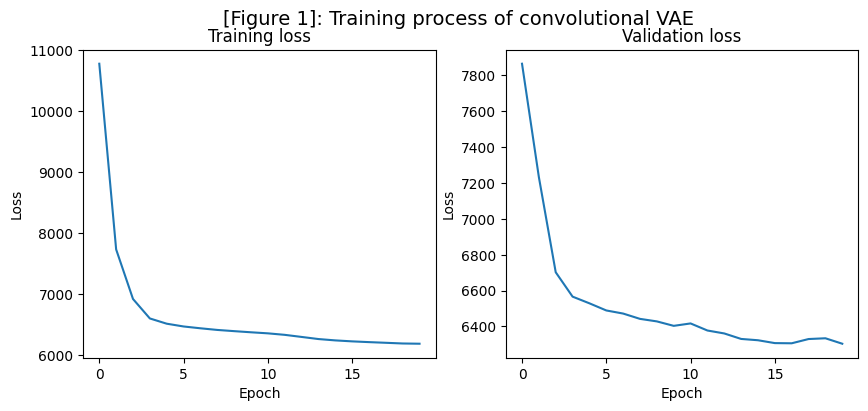

In [ ]:
# [Figure 1] Visualize training process for variational autoencoder

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(training_info['train_loss_hist'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training loss")
plt.subplot(1, 2, 2)
plt.plot(training_info['val_loss_hist'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Validation loss")
plt.suptitle("[Figure 1]: Training process of convolutional VAE", fontsize=14)
plt.show()

In [ ]:
# Load the VAE model which shows best validation loss
vae = VAE().to(device)
vae.load_state_dict(torch.load(os.path.join(model_path, "vae_best_val.pt")))

<All keys matched successfully>

In [ ]:
# [Interactive Demo 2] Latent representation and reconstruction of LOB using VAE

def visualize_vae(idx):
  lob_shot = example_orderbook.__getitem__(idx)
  lob_time = example_orderbook.__gettime__(idx)
  with torch.no_grad():
    input = torch.from_numpy(np.expand_dims(lob_shot, axis=0))
    input = input.to(device, dtype=torch.float)
    recon_x, mu, logsigma = vae(input)
    z = (mu + logsigma.exp() * torch.randn_like(mu))

  fig = plt.figure(figsize=(12, 4))
  gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[5, 1, 5])

  ax0 = fig.add_subplot(gs[0])
  ax0.imshow(lob_shot.squeeze(), cmap='gray')
  ax0.set_xlabel("Time (t-ΔT, t)")
  ax0.set_ylabel(r"$\{a_p, a_s, b_p, b_s\}_i$")
  ax0.set_title("a. Original input")
  ax1 = fig.add_subplot(gs[1])
  ax1.imshow(z.cpu().T, cmap='gray')
  ax1.set_xticks([])
  ax1.set_title("b. Latent representation")
  ax1.set_ylabel("Latent vector (z)")
  ax2 = fig.add_subplot(gs[2])
  ax2.imshow(recon_x.cpu().squeeze(), cmap='gray')
  ax2.set_xlabel("Time (t-ΔT, t)")
  ax2.set_ylabel(r"$\{a_p, a_s, b_p, b_s\}_i$")
  ax2.set_title("c. Reconstructed")

  plt.subplots_adjust(left=0.15, bottom=0.1, right=0.85, top=0.78,
                      wspace=0.4, hspace=0.1)
  plt.suptitle(f"[Interactive Demo 2:\
  Latent representation and reconstruction of LOB using VAE]\n\
  {DataConfig.TICKER}, {train_days[day_to_show]} {idx_to_time(lob_time[day_to_show])}",
  fontsize=14)
  plt.show()

widgets.interact(
    visualize_vae,
    idx=(0, example_orderbook.__len__()-1, 1))

interactive(children=(IntSlider(value=11353, description='idx', max=22706), Output()), _dom_classes=('widget-i…

<function __main__.visualize_vae(idx)>

In [ ]:
# [Interactive Demo 3] Generated LOB from random latent vector

def generate_from_latent(
    z1=random.random()*5-2.5, z2=random.random()*5-2.5, z3=random.random()*5-2.5,
    z4=random.random()*5-2.5, z5=random.random()*5-2.5, z6=random.random()*5-2.5,
    z7=random.random()*5-2.5, z8=random.random()*5-2.5, z9=random.random()*5-2.5,
    z10=random.random()*5-2.5, z11=random.random()*5-2.5, z12=random.random()*5-2.5,
    z13=random.random()*5-2.5, z14=random.random()*5-2.5, z15=random.random()*5-2.5,
    z16=random.random()*5-2.5):

  with torch.no_grad():
    z = np.array([z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12, z13, z14, z15, z16])
    z = np.expand_dims(z, axis=0)
    input = torch.from_numpy(z)
    input = input.to(device, dtype=torch.float)

    # lob_shot = np.squeeze(lob_shot)
    recon_x = vae.decoder(input)

  fig = plt.figure(figsize=(12, 4))
  gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 5])

  ax1 = fig.add_subplot(gs[0])
  ax1.imshow(z.T, cmap='gray')
  ax1.set_xticks([])
  ax1.set_title("a. Random latent vector")
  ax1.set_ylabel("Latent vector (z)")
  ax2 = fig.add_subplot(gs[1])
  ax2.imshow(recon_x.cpu().squeeze(), cmap='gray')
  ax2.set_xlabel("Time (t-ΔT, t)")
  ax2.set_ylabel(r"$\{a_p, a_s, b_p, b_s\}_i$")
  ax2.set_title("b. Reconstructed")

  plt.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.78,
                      wspace=0.4, hspace=0.1)
  plt.suptitle(f"[Interactive Demo 3: Generated LOB from random latent vector]",
  fontsize=14)
  plt.show()

z_dist = (-2.5, 2.5, 0.1)
widgets.interact(
    generate_from_latent,
    z1 = z_dist, z2 = z_dist, z3 = z_dist, z4 = z_dist,
    z5 = z_dist, z6 = z_dist, z7 = z_dist, z8 = z_dist,
    z9 = z_dist, z10 = z_dist, z11 = z_dist, z12 = z_dist,
    z13 = z_dist, z14 = z_dist, z15 = z_dist, z16 = z_dist)

interactive(children=(FloatSlider(value=-1.0887078996917783, description='z1', max=2.5, min=-2.5), FloatSlider…

<function __main__.generate_from_latent(z1=-1.0887078996917783, z2=0.07778727686588649, z3=2.1650367845083114, z4=-1.1584250512281458, z5=2.4710643114587647, z6=0.14873959425662875, z7=-1.2474020912804313, z8=0.6870698491364324, z9=-1.7903099280742123, z10=0.9838324443029478, z11=-2.402622414252905, z12=2.428949733510845, z13=0.6201073142931603, z14=0.039314111904340976, z15=0.8973194186522382, z16=-1.3562424809959894)>

In [ ]:
def fill_z(dataset):
  vae_loader = dataset.get_dataloader("VAE", 256, False, 2)

  for day_idx, day_loader in enumerate(vae_loader):
    day_dataset = dataset.day_datasets[day_idx]
    day_z = []
    for input in day_loader:
      with torch.no_grad():
        input = input.to(device, dtype=torch.float)
        mu, logsigma = vae.encoder(input)
        z = (mu + logsigma.exp() * torch.randn_like(mu)).cpu().detach().numpy()
        day_z.append(z)
    day_z = np.concatenate(day_z, 0)
    day_z = day_z[range(0, len(day_z), DataConfig.TRANSLATION_SLIDE),:]
    day_dataset.__fillz__(day_z)

def fill_action(dataset):
  for day_idx in range(len(dataset.day_datasets)):
    day_dataset = dataset.day_datasets[day_idx]
    day_action = []
    for index in range(0, day_dataset.__len__() - 1, DataConfig.TRANSLATION_SLIDE):
      tmp_time = day_dataset.orderbook.__gettime__(index)
      tmp_action = day_dataset.tradeprint.__getitem__(tmp_time, pad = True)
      day_action.append(np.multiply(tmp_action[:, 0], tmp_action[:, 2]))
    day_dataset.__fillaction__(np.array(day_action)/DataConfig.MAX_TRADE_QUANTITY)

def fill_midprice_change(dataset):
  for day_idx in range(len(dataset.day_datasets)):
    day_dataset = dataset.day_datasets[day_idx]
    day_midprice_change = []
    for index in range(0, day_dataset.__len__() - DataConfig.TRANSLATION_SLIDE, DataConfig.TRANSLATION_SLIDE):
      tmp_midprice = day_dataset.orderbook.__getmidprice__(index)
      tmp_midprice_next = day_dataset.orderbook.__getmidprice__(index+DataConfig.TRANSLATION_SLIDE)
      tmp_price_change = (tmp_midprice_next - tmp_midprice) / tmp_midprice
      day_midprice_change.append(tmp_price_change)

    day_dataset.__fillpricechange__(np.array(day_midprice_change))

def fill_secondary_data(dataset):
  fill_z(dataset)
  fill_action(dataset)
  fill_midprice_change(dataset)

fill_secondary_data(train_dataset)
fill_secondary_data(val_dataset)

### 2. Transition Model: Recurrent Neural Network + Mixture Density Network
Learning the probabilistic density between current and next state in deep latant space

In [ ]:
# Functions for z normalization and undo
Z_MAX = 1.8

def z_norm(z):
  z[np.where(z>Z_MAX)]=Z_MAX
  z[np.where(z<-Z_MAX)]=-Z_MAX
  min_max_norm = (z+Z_MAX)/(2*Z_MAX)
  return min_max_norm

def z_undo_norm(norm_z):
  norm_z[np.where(norm_z>1)]=1
  norm_z[np.where(norm_z<0)]=0
  undo_min_max_norm = norm_z*(2*Z_MAX)-Z_MAX
  return undo_min_max_norm

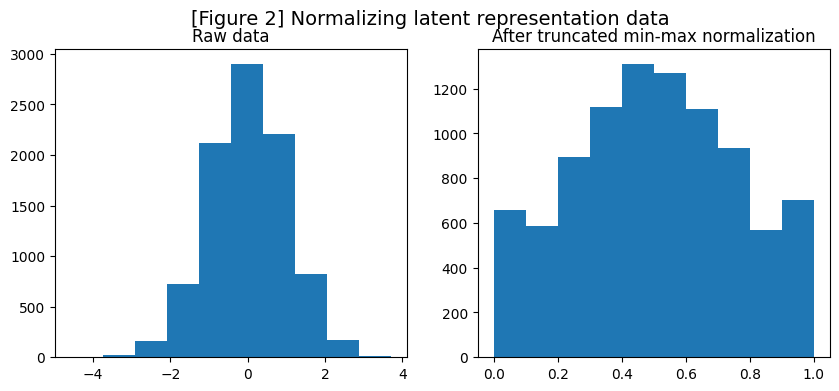

In [ ]:
# [Figure 2] Normalizing latent representation data

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(train_dataset.day_datasets[-1].z.flatten())
plt.title("Raw data")
plt.subplot(1, 2, 2)
plt.hist(z_norm(train_dataset.day_datasets[-1].z.flatten()))
plt.title("After truncated min-max normalization")
plt.suptitle("[Figure 2] Normalizing latent representation data", fontsize=14)
plt.show()

In [ ]:
class MDNRNNConfig:
  RNN_NEURONS = 128
  HIDDENS = 10
  N_GAUSSIAN = 5

  EPOCHS = 50
  LEARNING_RATE = 0.001

In [ ]:
class MDNRNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.latents = DataConfig.LATENT_SIZE
    self.actions = DataConfig.MAX_TRADEPRINT_LEN
    self.hiddens = MDNRNNConfig.HIDDENS
    self.gaussians = MDNRNNConfig.N_GAUSSIAN

    self.rnn = nn.LSTM(self.latents + self.actions, self.hiddens)
    gmm_out = (2 * self.latents + 1) * self.gaussians
    self.gmm_linear = nn.Linear(self.hiddens, gmm_out)

  def forward(self, latents, actions):
    seq_len, bs = actions.size(0), actions.size(1)

    ins = torch.cat([latents, actions], dim=-1)
    outs, _ = self.rnn(ins)
    gmm_outs = self.gmm_linear(outs)

    stride = self.gaussians * self.latents

    mus = gmm_outs[:, :, :stride]
    mus = mus.view(seq_len, bs, self.gaussians, self.latents)

    sigmas = gmm_outs[:, :, stride:2 * stride]
    sigmas = sigmas.view(seq_len, bs, self.gaussians, self.latents)
    sigmas = torch.exp(sigmas)

    pi = gmm_outs[:, :, 2 * stride: 2 * stride + self.gaussians]
    pi = pi.view(seq_len, bs, self.gaussians)
    logpi = F.log_softmax(pi, dim=-1)

    return mus, sigmas, logpi

In [ ]:
mdnrnn = MDNRNN().to(device)
mdnrnn_optimizer = torch.optim.Adam(mdnrnn.parameters(), lr=VAEConfig.LEARNING_RATE)

mdnrnn_train_loader = train_dataset.get_dataloader("MDNRNN", 256, True, 2)
mdnrnn_val_loader = val_dataset.get_dataloader("MDNRNN", 256, True, 2)

In [ ]:
def gmm_loss(batch, mus, sigmas, logpi, reduce=True):
  batch = batch.unsqueeze(-2)
  normal_dist = torch.distributions.normal.Normal(mus, sigmas)
  g_log_probs = normal_dist.log_prob(batch)
  g_log_probs = logpi + torch.sum(g_log_probs, dim=-1)
  max_log_probs = torch.max(g_log_probs, dim=-1, keepdim=True)[0]
  g_log_probs = g_log_probs - max_log_probs

  g_probs = torch.exp(g_log_probs)
  probs = torch.sum(g_probs, dim=-1)

  log_prob = max_log_probs.squeeze() + torch.log(probs)
  if reduce:
    return - torch.mean(log_prob)
  return - log_prob

def train_one_epoch():
  mdnrnn.train()
  train_loss = []

  for day_loader in mdnrnn_train_loader:
    for obs_z, action, obs_z_next in day_loader:
      obs_z = z_norm(obs_z)
      obs_z_next = z_norm(obs_z_next)
      obs_z = obs_z.to(device, dtype=torch.float)
      obs_z_next = obs_z_next.to(device, dtype=torch.float)
      action = action.to(device, dtype=torch.float)
      action = action / 10
      mdnrnn_optimizer.zero_grad()
      mus, sigmas, logpi = mdnrnn(obs_z, action)
      loss = gmm_loss(obs_z_next, mus, sigmas, logpi)
      loss.backward()
      mdnrnn_optimizer.step()
      train_loss.append(loss.item())
  train_loss = np.mean(train_loss)

  return train_loss

def validation_one_epoch():
  mdnrnn.eval()
  val_loss = []

  for day_loader in mdnrnn_val_loader:
    for obs_z, action, obs_z_next in day_loader:
      obs_z = z_norm(obs_z)
      obs_z_next = z_norm(obs_z_next)
      obs_z = obs_z.to(device, dtype=torch.float)
      obs_z_next = obs_z_next.to(device, dtype=torch.float)
      action = action.to(device, dtype=torch.float)
      action = action / 10

      mus, sigmas, logpi = mdnrnn(obs_z, action)
      loss = gmm_loss(obs_z_next, mus, sigmas, logpi)
      val_loss.append(loss.item())
  val_loss = np.mean(val_loss)

  return val_loss

def batch_gd():
  training_info = {
    'train_loss_hist': [],
    'val_loss_hist': [],
  }

  best_test_loss = np.inf
  best_test_epoch = 0

  for iter in range(MDNRNNConfig.EPOCHS):
    t0 = datetime.now()
    train_loss = train_one_epoch()
    val_loss = validation_one_epoch()

    # Save losses
    training_info['train_loss_hist'].append(train_loss)
    training_info['val_loss_hist'].append(val_loss)

    if val_loss < best_test_loss:
      torch.save(mdnrnn.state_dict(), os.path.join(model_path, "mdnrnn_best_val.pt"))
      best_test_loss = val_loss
      best_test_epoch = iter
      print('model saved')

    dt = datetime.now() - t0
    print(f'Epoch {iter + 1}/{MDNRNNConfig.EPOCHS}, '
          f'Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
          f'Duration: {dt}, Best Val Epoch: {best_test_epoch}')

  return training_info

training_info = batch_gd()


model saved
Epoch 1/50, Train Loss: 17.5099, Validation Loss: 17.3970, Duration: 0:00:02.568444, Best Val Epoch: 0
model saved
Epoch 2/50, Train Loss: 17.3598, Validation Loss: 17.2516, Duration: 0:00:01.502783, Best Val Epoch: 1
model saved
Epoch 3/50, Train Loss: 17.2151, Validation Loss: 17.1006, Duration: 0:00:01.473502, Best Val Epoch: 2
model saved
Epoch 4/50, Train Loss: 17.0582, Validation Loss: 16.9471, Duration: 0:00:01.492306, Best Val Epoch: 3
model saved
Epoch 5/50, Train Loss: 16.9001, Validation Loss: 16.7737, Duration: 0:00:01.527678, Best Val Epoch: 4
model saved
Epoch 6/50, Train Loss: 16.7196, Validation Loss: 16.5915, Duration: 0:00:01.467062, Best Val Epoch: 5
model saved
Epoch 7/50, Train Loss: 16.5170, Validation Loss: 16.3857, Duration: 0:00:01.797466, Best Val Epoch: 6
model saved
Epoch 8/50, Train Loss: 16.3047, Validation Loss: 16.1422, Duration: 0:00:02.168856, Best Val Epoch: 7
model saved
Epoch 9/50, Train Loss: 16.0429, Validation Loss: 15.8717, Duration:

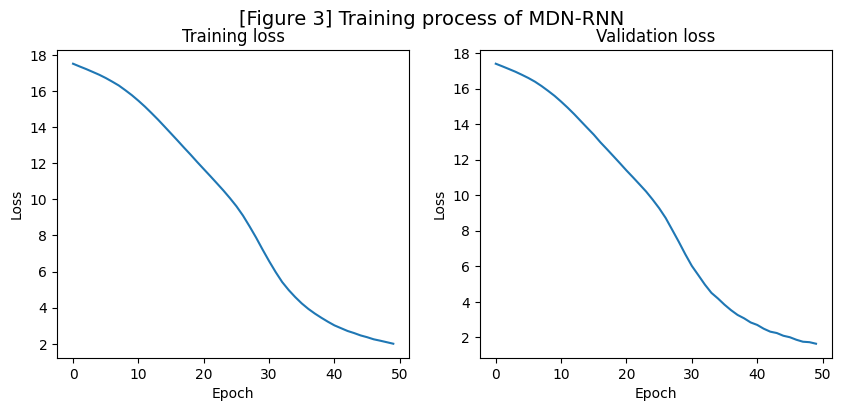

In [ ]:
# [Figure 3] Training process of MDN-RNN

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(training_info['train_loss_hist'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training loss")
plt.subplot(1, 2, 2)
plt.plot(training_info['val_loss_hist'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Validation loss")
plt.suptitle("[Figure 3] Training process of MDN-RNN", fontsize=14)
plt.show()

In [ ]:
# Load the MDNRNN model which shows best validation loss
mdnrnn = MDNRNN().to(device)
mdnrnn.load_state_dict(torch.load(os.path.join(model_path, "mdnrnn_best_val.pt")))

<All keys matched successfully>

In [ ]:
# [Interactive Demo 4] Predict the future state as mixture density

from torch.distributions.categorical import Categorical

example_dataset = train_dataset.day_datasets[-1]
example_dataset.mode = "MDNRNN"

def visualize_mdnrnn(idx):
  fig, axs = plt.subplots(nrows=4, ncols=1, height_ratios=[1.5, 1.5, 2, 1.3],
                          constrained_layout=True, figsize=(8, 7))
  fig.suptitle(f"[Interactive Demo 4] Predict the future state as mixture density", fontsize=14)
  for ax in axs:
    ax.remove()
  gridspec = axs[0].get_subplotspec().get_gridspec()
  subfigs = [fig.add_subfigure(gs) for gs in gridspec]

  obs = example_dataset.orderbook[idx*DataConfig.TRANSLATION_SLIDE]
  obs_next = example_dataset.orderbook[(idx+1)*DataConfig.TRANSLATION_SLIDE]
  obs_z, action, obs_z_next = example_dataset.__getitem__(idx)

  for i in range(2):
    match i:
      case 0:
        title = 'Current state S(t)'
        fig1 = obs.squeeze()
        fig2 = np.expand_dims(obs_z[-1,:], 0).T
        fig3_input = torch.from_numpy(obs_z[-1,:]).to(device, dtype=torch.float)
      case 1:
        title = 'Real future state S(t+1) (after transition)'
        fig1 = obs_next.squeeze()
        fig2 = np.expand_dims(obs_z_next[-1,:], 0).T
        fig3_input = torch.from_numpy(obs_z_next[-1,:]).to(device, dtype=torch.float)

    fig3 =  vae.decoder(fig3_input).squeeze().cpu().detach().numpy()
    subfigs[i].suptitle(title)
    axs = subfigs[i].subplots(nrows=1, ncols=3)
    axs[0].imshow(fig1, cmap='gray')
    axs[0].set_ylabel("")
    axs[0].set_title("a. Original input")
    axs[1].imshow(fig2, cmap='gray')
    axs[1].set_xticks([])
    axs[1].set_ylabel("z")
    axs[2].imshow(fig3, cmap='gray')
    axs[2].set_ylabel("")
    axs[2].set_title("c. Reconstructed")

  subfigs[2].suptitle("Predicted mixture of future state S(t+1) by MDN-RNN")
  axs = subfigs[2].subplots(nrows=1, ncols=6, width_ratios=[3, 1, 1, 1, 1, 1])

  with torch.no_grad():
    obs_z = z_norm(obs_z)
    obs_z = torch.from_numpy(np.expand_dims(obs_z, 0)).to(device, dtype=torch.float)
    action = torch.from_numpy(np.expand_dims(action, 0)).to(device, dtype=torch.float)
    mus, sigmas, logpi = mdnrnn(obs_z, action)

    axs[0].bar(range(1, 6), torch.exp(logpi[:,-1,:]).squeeze().cpu().detach().numpy())
    axs[0].set_xticks(range(1, 6),
                      ['Density 1', 'Density 2', 'Density 3', 'Density 4', 'Density 5'],
                      rotation=45)
    axs[0].set_ylabel("Gaussian mixture\ncoefficient")

    for idx in range(MDNRNNConfig.N_GAUSSIAN):
      mu = mus[:, -1, idx, :].squeeze()
      sigma = sigmas[:, -1, idx, :].squeeze()
      lstate = (mu + sigma * torch.rand_like(mu))

      axs[idx+1].imshow(lstate.unsqueeze(1).cpu().detach().numpy(), cmap='gray')
      axs[idx+1].set_xticks([0], [f'Density {idx+1}'], rotation=45)

    mixt = Categorical(torch.exp(logpi[:,-1,:])).sample().item()
    mu = mus[:, -1, mixt, :].squeeze()
    sigma = sigmas[:, -1, mixt, :].squeeze()
    lstate = (mu + sigma * torch.rand_like(mu)).cpu().detach().numpy()
    lstate = torch.from_numpy(z_undo_norm(lstate)).to(device, dtype=torch.float)

    recon_x = vae.decoder(lstate).squeeze().cpu().detach().numpy()
    subfigs[3].suptitle("Predicted future state S(t+1) sampled from Gaussian mixture")
    axs = subfigs[3].subplots(nrows=1, ncols=1)
    axs.imshow(recon_x, cmap='gray')
  plt.show()


widgets.interact(
    visualize_mdnrnn,
    idx=(0, example_dataset.__len__(), 1))

interactive(children=(IntSlider(value=285, description='idx', max=570), Output()), _dom_classes=('widget-inter…

<function __main__.visualize_mdnrnn(idx)>

### 3. Reward Model: Recurrent Neural Network + Fully Connected

In [ ]:
# Functions for reward(midprice change) normalization and undo

def reward_norm(price_change):
  min_max_norm = (price_change)/0.002
  sigmoid_trans = 1/(1 + np.exp(-min_max_norm))
  return sigmoid_trans

def reward_undo_norm(norm_price_change):
  undo_sigmoid_trans = -np.log(1/(norm_price_change+1e-8)-1)
  undo_min_max_norm = undo_sigmoid_trans*0.002
  return undo_min_max_norm

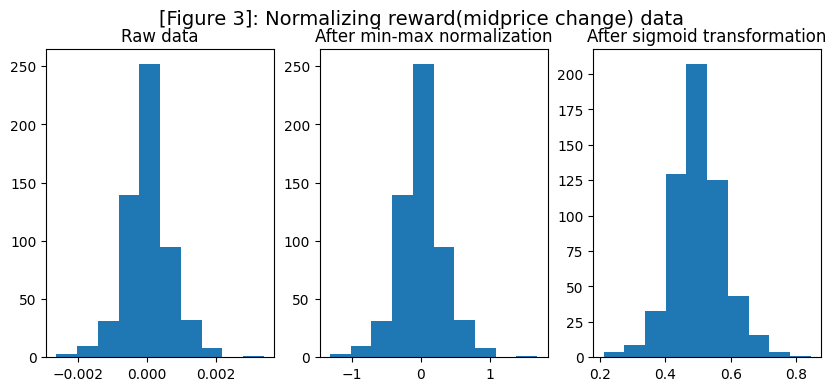

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.hist(train_dataset.day_datasets[-1].price_change)
plt.title("Raw data")
plt.subplot(1, 3, 2)
plt.hist(train_dataset.day_datasets[-1].price_change/0.002)
plt.title("After min-max normalization")
plt.subplot(1, 3, 3)
plt.hist(reward_norm(train_dataset.day_datasets[-1].price_change))
plt.title("After sigmoid transformation")
plt.suptitle("[Figure 3]: Normalizing reward(midprice change) data", fontsize=14)
plt.show()

In [ ]:
class RewardConfig:
  EPOCHS = 10
  LEARNING_RATE = 0.005

  RNN_NEURONS = 128
  HIDDENS = 40

In [ ]:
class RewardModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.latents = DataConfig.LATENT_SIZE
    self.neurons = RewardConfig.RNN_NEURONS
    self.hiddens = RewardConfig.HIDDENS

    self.rnn = nn.LSTM(2 * self.latents, self.neurons, batch_first=False)
    self.fc1 = nn.Linear(self.neurons, self.hiddens)
    self.fc2 = nn.Linear(self.hiddens, 1)

  def forward(self, z1, z2):
    x = torch.cat([z1, z2], dim=-1)
    x, _ = self.rnn(x)

    x = x.view(-1, self.neurons)
    x = F.relu(x)
    x = F.relu(self.fc1(x))
    forecast_y = self.fc2(x)
    return forecast_y

In [ ]:
reward_model = RewardModel().to(device)
reward_optimizer = torch.optim.Adam(reward_model.parameters(), lr=RewardConfig.LEARNING_RATE)

reward_train_loader = train_dataset.get_dataloader("REWARD", 256, True, 2)
reward_val_loader = val_dataset.get_dataloader("REWARD", 256, True, 2)

In [ ]:
def reward_loss(true, pred):
  mse_loss = (true - pred) ** 2
  weight = abs(true - reward_norm(0))
  # return torch.sum(mse_loss)
  return torch.sum(torch.multiply(mse_loss, weight))

def train_one_epoch():
  reward_model.train()
  train_loss = []

  for day_loader in reward_train_loader:
    for obs_z, obs_z_next, price_change in day_loader:
      obs_z = z_norm(obs_z)
      obs_z_next = z_norm(obs_z_next)
      obs_z = obs_z.to(device, dtype=torch.float)
      obs_z_next = obs_z_next.to(device, dtype=torch.float)
      price_change = reward_norm(price_change)
      price_change = price_change.to(device, dtype=torch.float)
      price_change = torch.unsqueeze(price_change, 1)

      reward_optimizer.zero_grad()
      pred = reward_model(obs_z, obs_z_next)
      loss = reward_loss(price_change, pred)
      loss.backward()
      reward_optimizer.step()
      train_loss.append(loss.item())
  train_loss = np.mean(train_loss)

  return train_loss

def validation_one_epoch():
  reward_model.eval()
  val_loss = []

  for day_loader in reward_val_loader:
    for obs_z, obs_z_next, price_change in day_loader:
      obs_z = z_norm(obs_z)
      obs_z_next = z_norm(obs_z_next)
      obs_z = obs_z.to(device, dtype=torch.float)
      obs_z_next = obs_z_next.to(device, dtype=torch.float)
      price_change = reward_norm(price_change)
      price_change = price_change.to(device, dtype=torch.float)
      price_change = torch.unsqueeze(price_change, 1)

      pred = reward_model(obs_z, obs_z_next)
      loss = reward_loss(price_change, pred)
      val_loss.append(loss.item())
  val_loss = np.mean(val_loss)

  return val_loss

def batch_gd():
  training_info = {
    'train_loss_hist': [],
    'val_loss_hist': [],
  }

  best_test_loss = np.inf
  best_test_epoch = 0

  for iter in range(RewardConfig.EPOCHS):
    t0 = datetime.now()
    train_loss = train_one_epoch()
    val_loss = validation_one_epoch()

    # Save losses
    training_info['train_loss_hist'].append(train_loss)
    training_info['val_loss_hist'].append(val_loss)

    if val_loss < best_test_loss:
      torch.save(reward_model.state_dict(), os.path.join(model_path, "reward_best_val.pt"))
      best_test_loss = val_loss
      best_test_epoch = iter
      print('model saved')

    dt = datetime.now() - t0
    print(f'Epoch {iter + 1}/{RewardConfig.EPOCHS}, '
          f'Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}, '
          f'Duration: {dt}, Best Val Epoch: {best_test_epoch}')

  return training_info

training_info = batch_gd()

model saved
Epoch 1/10, Train Loss: 0.47705281, Validation Loss: 0.07174594, Duration: 0:00:01.510890, Best Val Epoch: 0
model saved
Epoch 2/10, Train Loss: 0.11978133, Validation Loss: 0.04503648, Duration: 0:00:01.482695, Best Val Epoch: 1
model saved
Epoch 3/10, Train Loss: 0.10561722, Validation Loss: 0.03845433, Duration: 0:00:01.503666, Best Val Epoch: 2
model saved
Epoch 4/10, Train Loss: 0.09753676, Validation Loss: 0.03453969, Duration: 0:00:01.484688, Best Val Epoch: 3
model saved
Epoch 5/10, Train Loss: 0.08351980, Validation Loss: 0.02898294, Duration: 0:00:01.553564, Best Val Epoch: 4
model saved
Epoch 6/10, Train Loss: 0.07012265, Validation Loss: 0.02690920, Duration: 0:00:01.568983, Best Val Epoch: 5
model saved
Epoch 7/10, Train Loss: 0.04672753, Validation Loss: 0.01834606, Duration: 0:00:02.290280, Best Val Epoch: 6
Epoch 8/10, Train Loss: 0.04228343, Validation Loss: 0.02170652, Duration: 0:00:01.462842, Best Val Epoch: 6
model saved
Epoch 9/10, Train Loss: 0.042103

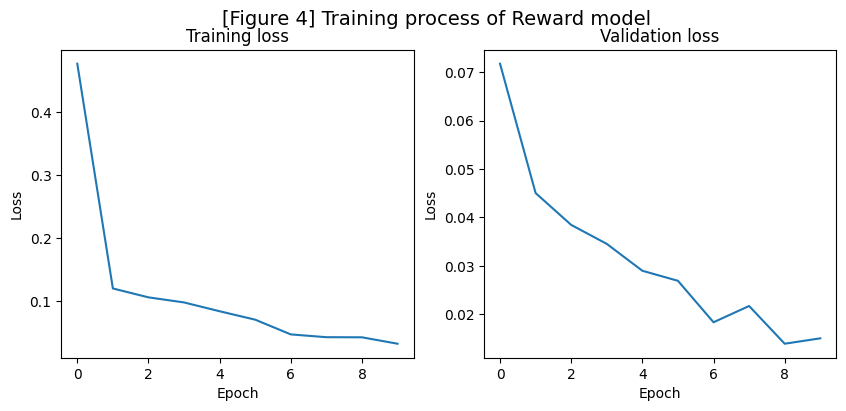

In [ ]:
# [Figure 4] Training process of Reward model

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(training_info['train_loss_hist'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training loss")
plt.subplot(1, 2, 2)
plt.plot(training_info['val_loss_hist'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Validation loss")
plt.suptitle("[Figure 4] Training process of Reward model", fontsize=14)
plt.show()

In [ ]:
# Load the reward model which shows best validation loss
reward_model = RewardModel().to(device)
reward_model.load_state_dict(torch.load(os.path.join(model_path, "reward_best_val.pt")))

<All keys matched successfully>

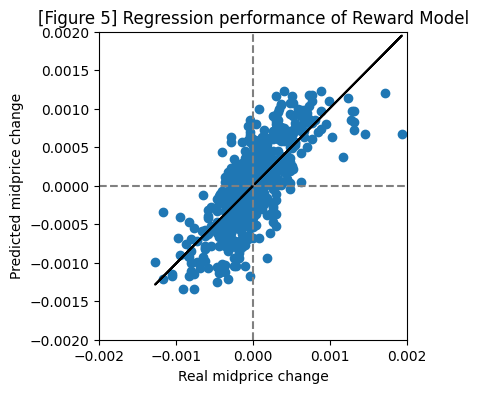

In [ ]:
# [Figure 5] Regression performance of Reward Model

price_change_true = []
price_change_pred = []

for day_loader in reward_val_loader:
  for obs_z, obs_z_next, price_change in day_loader:
    with torch.no_grad():
      price_change_true.append(price_change)
      obs_z = z_norm(obs_z)
      obs_z_next = z_norm(obs_z_next)
      obs_z = obs_z.to(device, dtype=torch.float)
      obs_z_next = obs_z_next.to(device, dtype=torch.float)
      price_change = reward_norm(price_change)
      price_change = price_change.to(device, dtype=torch.float)
      price_change = torch.unsqueeze(price_change, 1)

      pred = reward_model(obs_z, obs_z_next).cpu().detach().numpy()
      pred = reward_undo_norm(pred)
      price_change_pred.append(pred)

price_change_true = np.squeeze(np.concatenate(price_change_true, 0))
price_change_pred = np.squeeze(np.concatenate(price_change_pred, 0))

idx = np.where(np.abs(price_change_true)<0.002)
poly1d_fn = np.poly1d(np.polyfit(price_change_true[idx], price_change_pred[idx], 1))

plt.figure(figsize=(10, 4))
plt.axis('square')
plt.plot(price_change_true, price_change_pred, 'o',
         price_change_true, poly1d_fn(price_change_true), '-k')
plt.xlim(-0.002, 0.002)
plt.ylim(-0.002, 0.002)
plt.axhline(y=0, linestyle = '--', color = 'grey')
plt.axvline(x=0, linestyle = '--', color = 'grey')
plt.xlabel("Real midprice change")
plt.ylabel("Predicted midprice change")
plt.title("[Figure 5] Regression performance of Reward Model")
plt.show()

## Model-Based Reinforcement Learning

In [ ]:
!pip install git+https://github.com/openai/gym.git@9180d12e1b66e7e2a1a622614f787a6ec147ac40 --quiet
!pip install stable-baselines3 --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 5.3 MB/s eta 0:00:00


In [ ]:
import gym
from gym import spaces

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO, A2C

### 1. Markov Decision Process Formatting and Custom Gym Environment

In [ ]:
class RLConfig:
  EPISODES = 10
  TIME_HORIZON = 500

  N_ACTION = 21
  MAX_PROFIT = 100000000000
  INITIAL_BALANCE = 100000000
  INITIAL_ASSET_PRICE = 10000000

  TRADING_FEE = 0.003/100
  SLIPPAGE = 0.03/100*10

In [ ]:
# Helper function for reinforcement learning

def get_transition(obs_z, action):
  with torch.no_grad():
    obs_z = torch.from_numpy(np.expand_dims(obs_z, 0)).to(device, dtype=torch.float)
    action = torch.from_numpy(np.expand_dims(action, 0)).to(device, dtype=torch.float)
    mus, sigmas, logpi = mdnrnn(obs_z, action)

  mixt = Categorical(torch.exp(logpi[:,-1,:])).sample().item()
  mu = mus[:, -1, mixt, :].squeeze()
  sigma = sigmas[:, -1, mixt, :].squeeze()
  lstate = (mu + sigma * torch.rand_like(mu))
  return lstate.cpu().detach().numpy()

def get_midprice_change(obs_z, obs_z_next):
  with torch.no_grad():
    obs_z = torch.from_numpy(np.expand_dims(obs_z, 0)).to(device, dtype=torch.float)
    obs_z_next = torch.from_numpy(np.expand_dims(obs_z_next, 0)).to(device, dtype=torch.float)
    pred_reward = reward_model(obs_z, obs_z_next).squeeze().cpu().detach().numpy()
  return reward_undo_norm(pred_reward)

def get_initial_state():
  tmp_day_dataset = random.choice(train_dataset.day_datasets)
  return np.expand_dims(z_norm(tmp_day_dataset.z[0]), 1)

class DataQueue:
  def __init__(self):
    self.latent_queue = []
    self.action_queue = []
    for i in range(DataConfig.SEQ_LENGTH):
      self.latent_queue.append(np.zeros((DataConfig.LATENT_SIZE,)))
      self.action_queue.append(np.zeros((DataConfig.MAX_TRADEPRINT_LEN,)))

  def enqueue_latent(self, latent):
    self.latent_queue.pop(0)
    self.latent_queue.append(np.reshape(latent, (DataConfig.LATENT_SIZE,)))

  def enqueue_action(self, action, random_multi_agent = True):
    num_other_action = random.randint(0, int(DataConfig.MAX_TRADEPRINT_LEN)-1)
    temp_action = np.zeros((DataConfig.MAX_TRADEPRINT_LEN,))

    rand_agent_action = []
    if random_multi_agent == True:
      for i in range(num_other_action):
        tmp_action = random.randint(-10, 11)/10
        if tmp_action != 0:
          rand_agent_action.append(tmp_action)
      rand_agent_action.append(action/DataConfig.MAX_TRADE_QUANTITY)
      random.shuffle(rand_agent_action)

      for i in range(len(rand_agent_action)):
        temp_action[i] = rand_agent_action[i]
    else:
      if action != 0:
        temp_action[0] = action/DataConfig.MAX_TRADE_QUANTITY

    self.action_queue.pop(0)
    self.action_queue.append(temp_action)

  def get_all_state(self):
    return np.array(self.latent_queue), np.array(self.action_queue)

  def get_state(self, idx):
    return self.latent_queue[idx].squeeze(), self.action_queue[idx].squeeze()

In [ ]:
# OpenAI gym based RL environment using trained neural networks

class MarketEnv(gym.Env):
  metadata = {'render.modes': ['human']}

  def __init__(self):
    super(MarketEnv, self).__init__()
    self.reward_range = (-RLConfig.MAX_PROFIT, RLConfig.MAX_PROFIT)
    self.action_space = spaces.Discrete(RLConfig.N_ACTION)
    self.observation_space = spaces.Dict({
        'latent_vector': spaces.Box(low=0, high=1, shape=(DataConfig.LATENT_SIZE,)),
        'current_position': spaces.Box(low=-DataConfig.MAX_TRADE_QUANTITY,
                                       high=DataConfig.MAX_TRADE_QUANTITY,
                                       shape=(1,))
    })

  def _take_action(self, action):
    max_action = (RLConfig.N_ACTION-1)/2
    position_change = int((action-max_action)/max_action * DataConfig.MAX_TRADE_QUANTITY)

    if position_change > 0:
      available_amount = DataConfig.MAX_TRADE_QUANTITY - self.position
      position_change = min(position_change, available_amount)
    elif position_change < 0:
      available_amount =  - DataConfig.MAX_TRADE_QUANTITY - self.position
      position_change = max(position_change, available_amount)

    fee = abs(position_change) * self.asset_price * (RLConfig.TRADING_FEE + RLConfig.SLIPPAGE)
    return position_change, fee

  def _next_observation(self, position_change):
    self.data_queue.enqueue_action(position_change / DataConfig.MAX_TRADE_QUANTITY)
    obs_z_seq, action_seq = self.data_queue.get_all_state()
    obs_z_next = get_transition(obs_z_seq, action_seq)
    obs_z, __ = self.data_queue.get_state(-1)
    return obs_z, obs_z_next

  def step(self, action):
    position_change, fee = self._take_action(action)
    obs_z, obs_z_next = self._next_observation(position_change)
    midprice_change = get_midprice_change(obs_z, obs_z_next)

    reward = midprice_change * self.position * self.asset_price - fee
    self.current_step += 1
    self.balance += reward
    self.asset_price *= (1+midprice_change)
    self.position += position_change
    self.data_queue.enqueue_latent(obs_z_next)
    self.data_queue.enqueue_action(position_change)

    cum_reward = (self.balance/RLConfig.INITIAL_BALANCE-1)*100

    episode_over = (self.current_step == RLConfig.TIME_HORIZON)
    obs_z, __ = self.data_queue.get_state(-1)
    obs = {
      'latent_vector': obs_z,
      'current_position': self.position
    }

    info = {
        'midprice_change': midprice_change,
        'position_change': position_change,
        'fee': fee,
        'cum_reward': cum_reward
    }

    return obs, reward, episode_over, info

  def reset(self):
    self.position = 0
    self.current_step = 0

    self.balance = RLConfig.INITIAL_BALANCE
    self.asset_price = RLConfig.INITIAL_ASSET_PRICE

    initial_state = get_initial_state()
    self.data_queue = DataQueue()
    self.data_queue.enqueue_latent(initial_state)

    obs_z, __ = self.data_queue.get_state(-1)
    obs = {
      'latent_vector': obs_z,
      'current_position': self.position
    }
    return obs

  def render(self, mode='human', close=False):
    rate_of_return = (self.balance/RLConfig.INITIAL_BALANCE-1)*100
    benchmark_return = (self.asset_price/RLConfig.INITIAL_ASSET_PRICE-1)*100

    print(f'Step: {self.current_step}')
    print(f'Reward: {rate_of_return}')


### 2. Training Agent in Financial World Model
Model-based Simulated Market

In [ ]:
# Train agent inside financial world model

env = DummyVecEnv([lambda: MarketEnv()])
model = A2C("MultiInputPolicy", env, verbose=0)
model.learn(total_timesteps=20000)

In [ ]:
# Test agent in simulated market

cum_reward_history = []

for i_episode in range(RLConfig.EPISODES):
  observation = env.reset()
  cum_reward_episode = []
  for t in range(RLConfig.TIME_HORIZON):
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)
    cum_reward_episode.append(info[0]['cum_reward'])
  print(f"Episode {i_episode} finished: Final reward {info[0]['cum_reward']}")
  cum_reward_history.append(cum_reward_episode)

env.close()

Episode 0 finished: Final reward 21.928387089584845
Episode 1 finished: Final reward 18.20701696349669
Episode 2 finished: Final reward 18.769878015900975
Episode 3 finished: Final reward 17.284546394112276
Episode 4 finished: Final reward 21.441443556111793
Episode 5 finished: Final reward 18.084759307723218
Episode 6 finished: Final reward 19.398124173618836
Episode 7 finished: Final reward 17.40930292828704
Episode 8 finished: Final reward 16.874674583837002
Episode 9 finished: Final reward 20.49796327378013


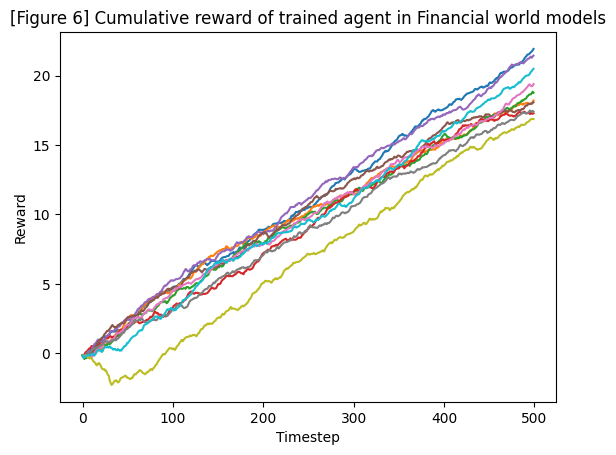

In [ ]:
# [Figure 6] Cumultative reward of trained agent in Financial world models

for i in range(RLConfig.EPISODES):
  plt.plot(cum_reward_history[i])
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.title("[Figure 6] Cumulative reward of trained agent in Financial world models")
plt.show()